<a href="https://colab.research.google.com/github/ailab-nda/NLP/blob/main/pytorch_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install scikit-learn==0.22.2 filterpy==1.1.0

     |████████████████████████████████| 7.1 MB 11.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for filterpy: filename=filterpy-1.1.0-py3-none-any.whl size=85437 sha256=540b10223cdcda36b66bd9a2c82559f8831a14c9da09cfbcd35609f92e7cda6f
  Stored in directory: /root/.cache/pip/wheels/5d/d1/d9/25c124a78a122e9d3b4d9c99daef4f818be8026ace6155de33
Successfully built filterpy
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.2 which is incompatible.


In [3]:
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git
% cd pytorch_objectdetecttrack/config/
! bash download_weights.sh

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
/content/pytorch_objectdetecttrack/config
--2022-01-06 10:14:49--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  21.0MB/s    in 12s     

2022-01-06 10:15:02 (19.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [4]:
% cd /content/pytorch_objectdetecttrack

/content/pytorch_objectdetecttrack


In [6]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [7]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.268940


<Figure size 432x288 with 0 Axes>

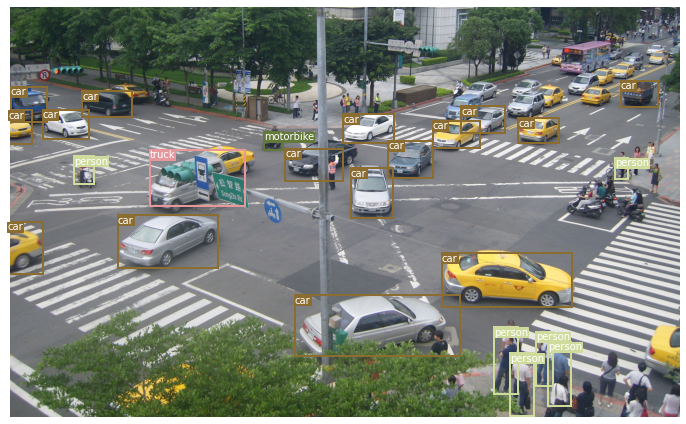

In [10]:
# load image and get detections
img_path = "images/Intersection-Counts.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [5]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [6]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

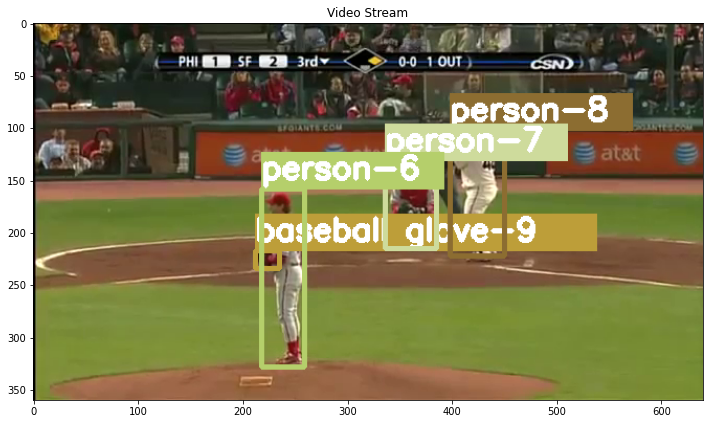

In [23]:
videopath = 'images/doubleplay.mp4'

%pylab inline 
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 

#while(True):
for ii in range(40):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)

In [43]:
!pip install youtube-dl
import youtube_dl

url = 'https://www.youtube.com/watch?v=wnRH3-CIk4I'
baseball_path = '/content/pytorch_objectdetecttrack/images/baseball'
baseball_video_path = os.path.join(baseball_path, 'video.mp4')
if not os.path.exists(baseball_path):
  os.mkdir(baseball_path)
vdl_opts = {'outtmpl':baseball_video_path, 'format':'bestvideo'}
vdl = youtube_dl.YoutubeDL(vdl_opts)
vdl.extract_info(url)

[youtube] wnRH3-CIk4I: Downloading webpage
[download] /content/pytorch_objectdetecttrack/images/baseball/video.mp4 has already been downloaded
[download] 100% of 35.80MiB


{'acodec': 'none',
 'age_limit': 0,
 'asr': None,
 'average_rating': None,
 'categories': ['Autos & Vehicles'],
 'channel': 'meiwadenki',
 'channel_id': 'UCkCjbbv4T8GEEhbeCzJHfwA',
 'channel_url': 'https://www.youtube.com/channel/UCkCjbbv4T8GEEhbeCzJHfwA',
 'container': 'mp4_dash',
 'description': '2012年元旦に郵便事業株式会社 博多支店で行われた\r\n「元旦配達出発式」の様子です。',
 'display_id': 'wnRH3-CIk4I',
 'downloader_options': {'http_chunk_size': 10485760},
 'duration': 115,
 'ext': 'mp4',
 'extractor': 'youtube',
 'extractor_key': 'Youtube',
 'filesize': 37535704,
 'format': '137 - 1920x1080 (1080p)',
 'format_id': '137',
 'format_note': '1080p',
 'formats': [{'abr': 42.163,
   'acodec': 'opus',
   'asr': 48000,
   'container': 'webm_dash',
   'downloader_options': {'http_chunk_size': 10485760},
   'ext': 'webm',
   'filesize': 608102,
   'format': '249 - audio only (tiny)',
   'format_id': '249',
   'format_note': 'tiny',
   'fps': None,
   'height': None,
   'http_headers': {'Accept': 'text/html,application/xhtm

In [46]:
baseball_img_path = os.path.join(baseball_path, 'img')
if not os.path.exists(baseball_img_path):
  os.mkdir(baseball_img_path)
!ffmpeg -i '$baseball_video_path' -vf trim=15:25,setpts=PTS-STARTPTS '$baseball_img_path/%04d.jpg'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [48]:
import cv2
import subprocess
from sort import *

mot_tracker = Sort()
cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
for img_path in os.listdir(baseball_img_path):
  frame = cv2.imread(os.path.join(baseball_img_path, img_path))
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  pilimg = Image.fromarray(frame)
  detections = detect_image(pilimg)
  img = np.array(pilimg)
  pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
  pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
  unpad_h = img_size - pad_y
  unpad_w = img_size - pad_x
  if detections is not None:
    tracked_objects = mot_tracker.update(detections.cpu())
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
      box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
      box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
      y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
      x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])
      color = colors[int(obj_id) % len(colors)]
      color = [i * 255 for i in color]
      cls = classes[int(cls_pred)]
      cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
      cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
      cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

  frame = cv2.cvtColor(frame.astype(np.float32), cv2.COLOR_RGB2BGR)
  cv2.imwrite(os.path.join(baseball_img_path, img_path), frame)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


/content/pytorch_objectdetecttrack


In [49]:
!ffmpeg -r 30 -i '$baseball_img_path/%04d.jpg' -vcodec libx264 -pix_fmt yuv420p -r 30 '$baseball_video_path'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [50]:
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/pytorch_objectdetecttrack/images/baseball/video.mp4"
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)